In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import pandas as pd
import copy
import math
from environments import SBEOS_Environment

# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a rollout buffer for storing experiences
class RolloutBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []
        self.logprobs = []
        self.state_values = []
        
    def push(self, state, action, reward, next_state, done, logprob, state_value):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)
        self.logprobs.append(logprob)
        self.state_values.append(state_value)
        
    def get(self):
        return (
            torch.FloatTensor(np.array(self.states)).to(device),
            torch.LongTensor(self.actions).to(device),
            torch.FloatTensor(self.rewards).to(device),
            torch.FloatTensor(np.array(self.next_states)).to(device),
            torch.FloatTensor(self.dones).to(device),
            torch.FloatTensor(self.logprobs).to(device),
            torch.FloatTensor(self.state_values).squeeze().to(device)
        )
    
    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []
        self.logprobs = []
        self.state_values = []
        
    def __len__(self):
        return len(self.states)

class ActorCriticLSTM(nn.Module):
    """Actor-Critic network with LSTM for temporal processing and concatenation approach"""
    def __init__(self, state_size, action_size, hidden_dim=128):
        super(ActorCriticLSTM, self).__init__()
        
        # Split state into window and statistical features
        self.window_size = state_size - 6  # Raw window part of state
        
        # LSTM for processing time series window data
        self.window_lstm = nn.LSTM(1, 32, batch_first=True)  # Process each window point individually
        
        # Linear layer for statistical features
        self.stats_layer = nn.Sequential(
            nn.Linear(6, 16),
            nn.LeakyReLU()
        )
        
        # Combined feature processing
        self.combined_layer = nn.Sequential(
            nn.Linear(32 + 16, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )
        
        # Actor network (policy)
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim // 2, action_size),
            nn.Softmax(dim=-1)
        )
        
        # Critic network (value function)
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def forward(self, x, hidden=None):
        # Split input into raw window and statistical features
        batch_size = x.size(0)
        window = x[:, :self.window_size]
        stats = x[:, self.window_size:]
        
        # Reshape window for LSTM processing
        window = window.view(batch_size, self.window_size, 1)  # [batch, seq_len, 1]
        
        # Process window through LSTM
        window_out, lstm_hidden = self.window_lstm(window, hidden)
        window_features = window_out[:, -1, :]  # Take the last LSTM output
        
        # Process statistical features
        stats_features = self.stats_layer(stats)
        
        # Combine features using concatenation
        combined = torch.cat([window_features, stats_features], dim=1)
        features = self.combined_layer(combined)
        
        # Get action probabilities and state value
        action_probs = self.actor(features)
        state_value = self.critic(features)
        
        return action_probs, state_value, lstm_hidden
    
    def act(self, state, hidden=None):
        # Convert state to tensor
        if isinstance(state, np.ndarray):
            state_tensor = torch.FloatTensor(state).to(device)
        else:
            state_tensor = torch.FloatTensor([state]).to(device)
            
        # Make sure it has batch dimension
        if state_tensor.dim() == 1:
            state_tensor = state_tensor.unsqueeze(0)
        
        # Get action probabilities and state value
        with torch.no_grad():
            action_probs, state_value, new_hidden = self.forward(state_tensor, hidden)
            
        # Create distribution and sample action
        dist = Categorical(action_probs)
        action = dist.sample()
        
        # Get log probability of the sampled action
        action_logprob = dist.log_prob(action)
        
        return action.item(), action_logprob.item(), state_value.item(), new_hidden
    
    def evaluate(self, states, actions, hidden=None):
        # Get action probabilities and state values for a batch of states
        action_probs, state_values, _ = self.forward(states, hidden)
        
        # Create distribution
        dist = Categorical(action_probs)
        
        # Get log probabilities for the chosen actions
        action_logprobs = dist.log_prob(actions)
        
        # Get entropy of the distribution (for exploration)
        dist_entropy = dist.entropy()
        
        return action_logprobs, state_values, dist_entropy

class PPOAgent:
    def __init__(
        self,
        state_size,
        action_size,
        learning_rate=0.0003,
        gamma=0.99,
        gae_lambda=0.95,
        clip_ratio=0.2,
        value_coef=0.5,
        entropy_coef=0.01,
        max_grad_norm=0.5,
        update_epochs=4,
        batch_size=64
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.clip_ratio = clip_ratio
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm
        self.update_epochs = update_epochs
        self.batch_size = batch_size
        
        # Initialize Actor-Critic network
        self.policy = ActorCriticLSTM(state_size, action_size).to(device)
        
        # Initialize optimizer
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        
        # Initialize rollout buffer
        self.buffer = RolloutBuffer()
        
        # LSTM hidden state
        self.hidden = None
        
        # Training metrics
        self.rewards_history = []
        self.losses = []
        self.predictions = []
        self.true_states = []
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=10, verbose=True
        )
        
    def select_action(self, state, evaluate=False):
        """Select an action using policy"""
        if evaluate:
            # For evaluation, select the action with highest probability
            with torch.no_grad():
                if isinstance(state, np.ndarray):
                    state_tensor = torch.FloatTensor(state).to(device)
                else:
                    state_tensor = torch.FloatTensor([state]).to(device)
                    
                # Make sure it has batch dimension
                if state_tensor.dim() == 1:
                    state_tensor = state_tensor.unsqueeze(0)
                
                # Get action probabilities
                action_probs, _, new_hidden = self.policy(state_tensor, self.hidden)
                
                # Select action with highest probability
                action = torch.argmax(action_probs, dim=1).item()
                self.hidden = new_hidden
                return action
        else:
            # For training, sample from the probability distribution
            action, logprob, state_value, new_hidden = self.policy.act(state, self.hidden)
            self.hidden = new_hidden
            return action, logprob, state_value
    
    def remember(self, state, action, reward, next_state, done, logprob, state_value):
        """Store experience in rollout buffer"""
        self.buffer.push(state, action, reward, next_state, done, logprob, state_value)
    
    def compute_advantages(self, rewards, values, dones):
        """Compute advantages using Generalized Advantage Estimation (GAE)"""
        advantages = torch.zeros_like(rewards)
        returns = torch.zeros_like(rewards)
        
        # Compute returns (discounted sum of rewards)
        last_return = 0
        last_advantage = 0
        
        for t in reversed(range(len(rewards))):
            # If episode is done, reset
            mask = 1.0 - dones[t]
            
            # Calculate returns (for value loss)
            if t == len(rewards) - 1:
                # No next state value for the last step
                returns[t] = rewards[t]
            else:
                returns[t] = rewards[t] + self.gamma * returns[t+1] * mask
            
            # Calculate TD error
            if t == len(rewards) - 1:
                # No next state value for the last step
                td_error = rewards[t] - values[t]
            else:
                td_error = rewards[t] + self.gamma * values[t+1] * mask - values[t]
            
            # Calculate advantages using GAE
            advantages[t] = td_error + self.gamma * self.gae_lambda * last_advantage * mask
            last_advantage = advantages[t]
        
        return returns, advantages
    
    def update(self):
        """Update policy using PPO algorithm"""
        # Get experiences from buffer
        states, actions, rewards, next_states, dones, old_logprobs, old_values = self.buffer.get()
        
        # Compute advantages and returns
        returns, advantages = self.compute_advantages(rewards, old_values, dones)
        
        # Normalize advantages (for stable training)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Perform multiple update epochs
        total_loss = 0
        
        for _ in range(self.update_epochs):
            # Create mini-batches
            batch_indices = torch.randperm(len(states))
            
            for start_idx in range(0, len(states), self.batch_size):
                # Get mini-batch indices
                batch_idx = batch_indices[start_idx:start_idx + self.batch_size]
                
                # Get mini-batch data
                batch_states = states[batch_idx]
                batch_actions = actions[batch_idx]
                batch_advantages = advantages[batch_idx]
                batch_returns = returns[batch_idx]
                batch_old_logprobs = old_logprobs[batch_idx]
                
                # Evaluate actions and values
                new_logprobs, new_values, entropy = self.policy.evaluate(batch_states, batch_actions)
                
                # Calculate ratios for PPO
                ratios = torch.exp(new_logprobs - batch_old_logprobs)
                
                # Calculate surrogate losses
                surr1 = ratios * batch_advantages
                surr2 = torch.clamp(ratios, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio) * batch_advantages
                
                # Calculate actor loss (negative because we're maximizing)
                actor_loss = -torch.min(surr1, surr2).mean()
                
                # Calculate critic loss (MSE)
                critic_loss = F.mse_loss(new_values, batch_returns)
                
                # Calculate entropy loss (for exploration)
                entropy_loss = -entropy.mean()
                
                # Total loss
                loss = actor_loss + self.value_coef * critic_loss + self.entropy_coef * entropy_loss
                
                # Perform backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                
                # Gradient clipping (to prevent exploding gradients)
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
                
                # Update policy
                self.optimizer.step()
                
                # Accumulate loss
                total_loss += loss.item()
        
        # Clear buffer after update
        self.buffer.clear()
        
        # Return average loss
        return total_loss / (self.update_epochs * (len(states) // self.batch_size + 1))
    
    def save_model(self, filepath):
        """Save model weights"""
        torch.save({
            'policy': self.policy.state_dict(),
            'optimizer': self.optimizer.state_dict(),
        }, filepath)
        
    def load_model(self, filepath):
        """Load model weights"""
        checkpoint = torch.load(filepath)
        self.policy.load_state_dict(checkpoint['policy'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])


def evaluate_episode(env, agent):
    """Evaluate the agent on a single episode without exploration"""
    state = env.reset()
    done = False
    total_reward = 0
    agent.hidden = None  # Reset hidden state
    
    while not done:
        # Select action without exploration
        action = agent.select_action(state, evaluate=True)
        
        # Execute action
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        
        # Update state
        state = next_state
    
    return total_reward


def train_ppo(env, agent, episodes=500, steps_per_update=2048, eval_freq=10):
    """Train the PPO agent"""
    # Record best model for early stopping
    best_reward = float('-inf')
    best_model = None
    no_improvement_count = 0
    
    # Training metrics
    episode_rewards = []
    all_predictions = []
    all_true_states = []
    training_losses = []
    
    # Episode window for tracking improvement
    window_size = 10
    window_rewards = deque(maxlen=window_size)
    
    # Training loop
    total_steps = 0
    episode = 0
    
    with tqdm(total=episodes, desc="Training PPO") as pbar:
        while episode < episodes:
            # Reset environment and agent state
            state = env.reset()
            episode_reward = 0
            done = False
            
            # Reset LSTM hidden state
            agent.hidden = None
            
            # Episode experience collection
            episode_predictions = []
            episode_true_states = []
            
            # Collect experience until we have enough steps or episode ends
            while not done:
                # Select action
                action, logprob, state_value = agent.select_action(state)
                
                # Execute action
                next_state, reward, done, info = env.step(action)
                
                # Record prediction and true state
                episode_predictions.append(action % 2)  # Binary prediction: 0 or 1
                episode_true_states.append(info["state"])
                
                # Store experience
                agent.remember(state, action, reward, next_state, done, logprob, state_value)
                
                # Update state
                state = next_state
                episode_reward += reward
                total_steps += 1
                
                # Update policy if we have enough steps
                if len(agent.buffer) >= steps_per_update:
                    loss = agent.update()
                    training_losses.append(loss)
            
            # Record episode metrics
            episode_rewards.append(episode_reward)
            all_predictions.extend(episode_predictions)
            all_true_states.extend(episode_true_states)
            window_rewards.append(episode_reward)
            
            # Calculate accuracy for the episode
            episode_accuracy = np.mean(np.array(episode_predictions) == np.array(episode_true_states))
            
            # Print progress
            if (episode + 1) % 10 == 0:
                window_avg = np.mean(window_rewards)
                pbar.set_postfix({
                    'Episode': episode + 1,
                    'Reward': f"{episode_reward:.2f}",
                    'Avg Reward': f"{window_avg:.2f}",
                    'Accuracy': f"{episode_accuracy:.4f}",
                    'Steps': total_steps
                })
                
                # Update learning rate based on performance
                agent.scheduler.step(window_avg)
            
            # Save best model
            if len(window_rewards) == window_size:
                window_avg = np.mean(window_rewards)
                if window_avg > best_reward:
                    best_reward = window_avg
                    best_model = copy.deepcopy(agent.policy.state_dict())
                    no_improvement_count = 0
                    print(f"\nNew best model saved! Avg reward: {best_reward:.2f}")
                else:
                    no_improvement_count += 1
            
            # Early stopping if no improvement for a while
            if no_improvement_count >= 30:
                print(f"\nEarly stopping after {episode+1} episodes - no improvement for 30 episodes")
                if best_model is not None:
                    agent.policy.load_state_dict(best_model)
                break
                    
            # Evaluate agent periodically
            if (episode + 1) % eval_freq == 0:
                eval_reward = evaluate_episode(env, agent)
                print(f"\nEvaluation at episode {episode+1}: Reward = {eval_reward:.2f}")
                
            # Increment episode counter
            episode += 1
            pbar.update(1)
    
    # Update agent metrics
    agent.rewards_history = episode_rewards
    agent.losses = training_losses
    agent.predictions = all_predictions
    agent.true_states = all_true_states
    
    # If training completed without early stopping, load best model
    if best_model is not None and episode == episodes:
        agent.policy.load_state_dict(best_model)
        
    # Calculate final accuracy
    final_accuracy = np.mean(np.array(all_predictions) == np.array(all_true_states))
    print(f"Training completed. Final accuracy: {final_accuracy:.4f}")
    
    return agent, episode_rewards, training_losses


def plot_training_results(rewards, losses, predictions=None, true_states=None):
    """Plot training metrics and model performance"""
    plt.figure(figsize=(18, 10))
    
    # Plot rewards
    plt.subplot(2, 2, 1)
    plt.plot(rewards, label='Episode Reward')
    plt.plot(pd.Series(rewards).rolling(10).mean(), 'r-', label='Moving Average (10)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.legend()
    plt.grid(True)
    
    # Plot losses
    plt.subplot(2, 2, 2)
    plt.plot(losses)
    plt.xlabel('Update')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    
    # Plot accuracy if predictions and true states are provided
    if predictions is not None and true_states is not None:
        plt.subplot(2, 2, 3)
        
        # Calculate accuracy over time
        window = 100
        accuracies = []
        for i in range(0, len(predictions), window):
            end = min(i + window, len(predictions))
            acc = np.mean(np.array(predictions[i:end]) == np.array(true_states[i:end]))
            accuracies.append(acc)
        
        plt.plot(range(0, len(predictions), window), accuracies)
        plt.xlabel('Steps')
        plt.ylabel('Accuracy')
        plt.title('Prediction Accuracy')
        plt.grid(True)
        
        # Confusion matrix
        plt.subplot(2, 2, 4)
        cm = confusion_matrix(true_states, predictions)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        
        classes = ['State 0', 'State 1']
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        
        plt.ylabel('True State')
        plt.xlabel('Predicted State')
    
    plt.tight_layout()
    plt.show()


def run_experiment(env, seed=42, episodes=300):
    """Run a complete experiment with the provided environment and PPO agent"""
    # Set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Get state and action dimensions
    state_dim = len(env.generate_observation_state())
    action_dim = 2  # Binary prediction: 0 or 1
    
    # Create PPO agent
    agent = PPOAgent(
        state_size=state_dim,
        action_size=action_dim,
        learning_rate=0.0003,
        gamma=0.99,
        gae_lambda=0.95,
        clip_ratio=0.2,
        value_coef=0.5,
        entropy_coef=0.01,
        max_grad_norm=0.5,
        update_epochs=4,
        batch_size=64
    )
    
    # Train agent
    trained_agent, rewards, losses = train_ppo(
        env, agent, episodes=episodes, steps_per_update=2048, eval_freq=20
    )
    
    # Plot results
    plot_training_results(rewards, losses, 
                          predictions=trained_agent.predictions, 
                          true_states=trained_agent.true_states)
    
    # Evaluate final performance
    eval_rewards = []
    for _ in range(20):  # Run 20 evaluation episodes
        reward = evaluate_episode(env, trained_agent)
        eval_rewards.append(reward)
    
    avg_reward = np.mean(eval_rewards)
    print(f"Final evaluation - Average reward over 20 episodes: {avg_reward:.2f}")
    
    # Save the trained model
    trained_agent.save_model("ppo_lstm_model.pt")
    
    return trained_agent

# Example usage:
# from environments import SBEOS_Environment
# env = SBEOS_Environment(max_timesteps=500, window_size=25, time_dependence=3)
# agent = run_experiment(env, episodes=300)

Starting PPO experiment with separate training and testing environments


/home/ayush/Ayush/EE_Spectrum_Hole_Detection_with_RL/myenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training PPO:   1%|          | 4/500 [00:03<06:10,  1.34it/s]/tmp/ipykernel_137216/3973634508.py:331: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(new_values, batch_returns)
Training PPO:   2%|▏         | 10/500 [00:08<07:21,  1.11it/s, Episode=10, Reward=1455.00, Avg Reward=1347.00, Accuracy=0.5269, Steps=5010]


New best model saved! Avg reward: 1347.00


Training PPO:   2%|▏         | 11/500 [00:09<06:51,  1.19it/s, Episode=10, Reward=1455.00, Avg Reward=1347.00, Accuracy=0.5269, Steps=5010]


New best model saved! Avg reward: 1357.50


Training PPO:   3%|▎         | 13/500 [00:11<07:59,  1.02it/s, Episode=10, Reward=1455.00, Avg Reward=1347.00, Accuracy=0.5269, Steps=5010]


New best model saved! Avg reward: 1359.00


Training PPO:   3%|▎         | 14/500 [00:12<07:24,  1.09it/s, Episode=10, Reward=1455.00, Avg Reward=1347.00, Accuracy=0.5269, Steps=5010]


New best model saved! Avg reward: 1405.50


Training PPO:   4%|▍         | 20/500 [00:17<07:34,  1.06it/s, Episode=20, Reward=1275.00, Avg Reward=1182.00, Accuracy=0.5030, Steps=1e+4]


Evaluation at episode 20: Reward = 2685.00


Training PPO:   8%|▊         | 38/500 [00:34<06:59,  1.10it/s, Episode=30, Reward=1590.00, Avg Reward=1191.00, Accuracy=0.5449, Steps=15030]


New best model saved! Avg reward: 1407.00


Training PPO:   8%|▊         | 39/500 [00:34<06:30,  1.18it/s, Episode=30, Reward=1590.00, Avg Reward=1191.00, Accuracy=0.5449, Steps=15030]


New best model saved! Avg reward: 1410.00


Training PPO:   8%|▊         | 40/500 [00:36<07:18,  1.05it/s, Episode=40, Reward=1185.00, Avg Reward=1369.50, Accuracy=0.4910, Steps=2e+4] 


Evaluation at episode 40: Reward = 855.00


Training PPO:  12%|█▏        | 60/500 [00:54<07:06,  1.03it/s, Episode=60, Reward=1515.00, Avg Reward=1285.50, Accuracy=0.5349, Steps=30060]


Evaluation at episode 60: Reward = 1800.00


Training PPO:  13%|█▎        | 65/500 [00:58<06:14,  1.16it/s, Episode=60, Reward=1515.00, Avg Reward=1285.50, Accuracy=0.5349, Steps=30060]


New best model saved! Avg reward: 1431.00


Training PPO:  13%|█▎        | 66/500 [01:00<07:24,  1.02s/it, Episode=60, Reward=1515.00, Avg Reward=1285.50, Accuracy=0.5349, Steps=30060]


New best model saved! Avg reward: 1440.00


Training PPO:  16%|█▌        | 80/500 [01:12<06:54,  1.01it/s, Episode=80, Reward=780.00, Avg Reward=1165.50, Accuracy=0.4371, Steps=40080] 


Evaluation at episode 80: Reward = 4125.00


Training PPO:  19%|█▉        | 95/500 [01:26<06:10,  1.09it/s, Episode=90, Reward=450.00, Avg Reward=1263.00, Accuracy=0.3932, Steps=45090]


Early stopping after 96 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.5019


Test evaluation - Average reward over 100 episodes: 1186.20


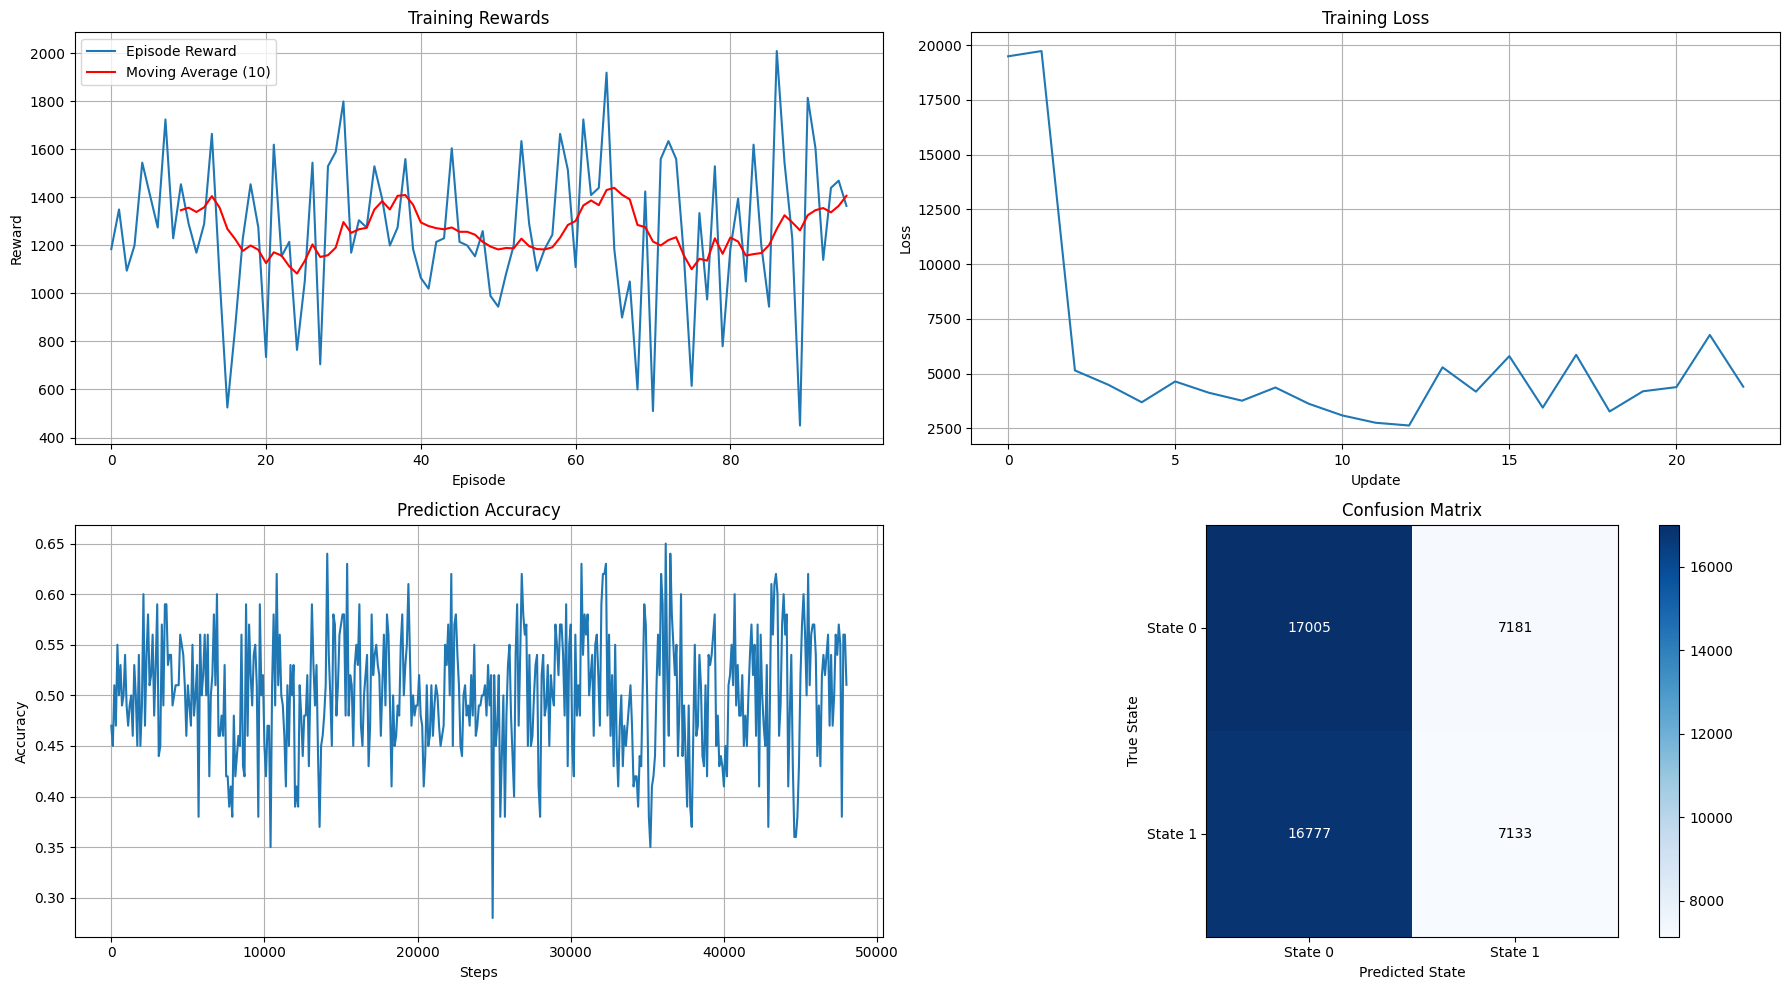

Experiment completed!


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
import pandas as pd
import random
from collections import deque
from scipy.stats import entropy

def create_test_environment(seed=None):
    """Create a separate test environment with a different random seed"""
    # Use a different seed for the test environment to ensure different data generation
    if seed is not None:
        np.random.seed(seed)  # Set the numpy random seed
    
    test_env = SBEOS_Environment(max_timesteps=500, window_size=25, time_dependence=time_dependence)
    return test_env


def evaluate_on_test_environment(agent, test_env, num_episodes=100):
    """Evaluate PPO agent performance on a separate test environment"""
    test_rewards = []
    test_predictions = []
    test_true_states = []
    
    print("\nEvaluating on test environment...")
    
    for i in range(num_episodes):
        state = test_env.reset()
        episode_reward = 0
        done = False
        hidden = None  # Initialize RNN hidden state if using recurrent policy
        
        episode_predictions = []
        episode_true_states = []
        
        # Run until episode ends
        while not done:
            # Select action without exploration (using only the mean of the policy distribution)
            with torch.no_grad():
                action, _, _, hidden = agent.policy.act(state, hidden, deterministic=True)
            
            # Execute action
            next_state, reward, done, info = test_env.step(action)
            
            # Record prediction and true state
            episode_predictions.append(action % 2)  # Convert action to binary prediction
            episode_true_states.append(info["state"])
            
            episode_reward += reward
            
            # Update state
            state = next_state
        
        # Store episode results
        test_rewards.append(episode_reward)
        test_predictions.extend(episode_predictions)
        test_true_states.extend(episode_true_states)
        
        if (i + 1) % 10 == 0:
            print(f"Test episode {i+1}/{num_episodes} completed. Reward: {episode_reward:.2f}")
    
    # Calculate overall metrics
    avg_test_reward = np.mean(test_rewards)
    test_accuracy = accuracy_score(test_true_states, test_predictions)
    
    print(f"\nTest Results Summary:")
    print(f"Average reward: {avg_test_reward:.2f}")
    print(f"Prediction accuracy: {test_accuracy:.4f}")
    
    return {
        'rewards': test_rewards,
        'predictions': test_predictions,
        'true_states': test_true_states,
        'avg_reward': avg_test_reward,
        'accuracy': test_accuracy
    }


def plot_test_results(test_results):
    """Plot comprehensive test results including metrics and visualizations"""
    plt.figure(figsize=(20, 12))
    
    # Plot test rewards
    plt.subplot(2, 3, 1)
    plt.plot(test_results['rewards'])
    plt.plot(pd.Series(test_results['rewards']).rolling(5).mean(), 'r-', label='Moving Average (5)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Test Rewards (Avg: {test_results["avg_reward"]:.2f})')
    plt.legend()
    plt.grid(True)
    
    # Plot confusion matrix
    plt.subplot(2, 3, 2)
    cm = confusion_matrix(test_results['true_states'], test_results['predictions'])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix (Acc: {test_results["accuracy"]:.4f})')
    plt.colorbar()
    
    classes = ['State 0', 'State 1']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True State')
    plt.xlabel('Predicted State')
    
    # Plot ROC curve
    plt.subplot(2, 3, 3)
    y_true = np.array(test_results['true_states'])
    y_pred = np.array(test_results['predictions'])
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    # Plot prediction vs true state over time
    plt.subplot(2, 3, 4)
    # Sample a subset of the data for readability
    sample_size = min(500, len(test_results['predictions']))
    sample_indices = np.linspace(0, len(test_results['predictions'])-1, sample_size, dtype=int)
    
    plt.plot(np.array(test_results['true_states'])[sample_indices], 'b-', label='True State')
    plt.plot(np.array(test_results['predictions'])[sample_indices], 'r.', label='Predicted State')
    plt.xlabel('Step')
    plt.ylabel('State')
    plt.title('Prediction vs True State')
    plt.legend()
    plt.grid(True)
    
    # Plot class-wise precision and recall
    plt.subplot(2, 3, 5)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, label=f'Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    
    # Plot histogram of prediction errors
    plt.subplot(2, 3, 6)
    errors = np.array(test_results['predictions']) != np.array(test_results['true_states'])
    error_indices = np.where(errors)[0]
    
    # Create a histogram of error locations
    if len(error_indices) > 0:
        plt.hist(error_indices, bins=30)
        plt.xlabel('Step Index')
        plt.ylabel('Error Count')
        plt.title(f'Distribution of Prediction Errors (Total: {len(error_indices)})')
    else:
        plt.text(0.5, 0.5, 'No prediction errors!', ha='center', va='center')
        plt.title('Distribution of Prediction Errors')
    
    plt.tight_layout()
    plt.show()
    
    return plt


def compare_train_test_performance(train_results, test_results):
    """Compare training and test performance to assess overfitting"""
    train_accuracy = np.mean(np.array(train_results['predictions']) == np.array(train_results['true_states']))
    test_accuracy = test_results['accuracy']
    
    print("\nTraining vs Test Performance:")
    print(f"Training accuracy: {train_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Accuracy difference: {abs(train_accuracy - test_accuracy):.4f}")
    
    if test_accuracy < 0.9 * train_accuracy:
        print("WARNING: Possible overfitting detected. Test accuracy is significantly lower than training accuracy.")
    else:
        print("Model generalizes well to the test environment.")
    
    # Create visualization of train vs test metrics
    plt.figure(figsize=(15, 6))
    
    # Compare accuracies
    plt.subplot(1, 2, 1)
    plt.bar(['Training', 'Test'], [train_accuracy, test_accuracy])
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')
    plt.ylim([0, 1])
    plt.grid(axis='y')
    
    # Compare average rewards
    train_avg_reward = np.mean(train_results['rewards'])
    test_avg_reward = test_results['avg_reward']
    
    plt.subplot(1, 2, 2)
    plt.bar(['Training', 'Test'], [train_avg_reward, test_avg_reward])
    plt.ylabel('Average Reward')
    plt.title('Reward Comparison')
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return plt


def collect_training_stats(agent, env, timesteps=1000):
    """Collect training statistics to compare with test performance"""
    state = env.reset()
    done = False
    predictions = []
    true_states = []
    rewards = []
    total_reward = 0
    hidden = None
    
    for _ in range(timesteps):
        # Use the policy to get an action (without exploration)
        with torch.no_grad():
            action, _, _, hidden = agent.policy.act(state, hidden, deterministic=True)
        
        # Take the action
        next_state, reward, done, info = env.step(action)
        
        # Record prediction and true state
        predictions.append(action % 2)
        true_states.append(info["state"])
        
        total_reward += reward
        
        # Reset if episode ended
        if done:
            rewards.append(total_reward)
            total_reward = 0
            state = env.reset()
            hidden = None
        else:
            state = next_state
    
    return {
        'predictions': predictions,
        'true_states': true_states,
        'rewards': rewards if rewards else [total_reward]
    }

def run_experiment_with_testing(timesteps=100000, test_episodes=100):
    """Run a complete experiment with separate training and testing environments"""
    # Set random seeds
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    
    # Create environments
    train_env = SBEOS_Environment(max_timesteps=500, window_size=25, time_dependence=3)
    test_env = SBEOS_Environment(max_timesteps=500, window_size=25, time_dependence=3)
    
    # Get state and action dimensions
    state_size = len(train_env.generate_observation_state())
    action_size = 2  # Binary prediction: 0 or 1
    
    # Create PPO agent - using the correct parameter names
    agent = PPOAgent(
        state_size=state_size,
        action_size=action_size,
        learning_rate=0.0003,
        gamma=0.99,
        gae_lambda=0.95,
        clip_ratio=0.2,
        value_coef=0.5,
        entropy_coef=0.01,
        max_grad_norm=0.5,
        update_epochs=4,
        batch_size=64
    )
    
    # Train agent
    trained_agent, train_rewards, train_losses = train_ppo(
        train_env, agent, episodes=500, steps_per_update=2048, eval_freq=20
    )
    
    # Evaluate on test environment
    test_results = []
    for _ in range(test_episodes):
        reward = evaluate_episode(test_env, trained_agent)
        test_results.append(reward)
    
    avg_test_reward = np.mean(test_results)
    print(f"Test evaluation - Average reward over {test_episodes} episodes: {avg_test_reward:.2f}")
    
    # Plot training results
    train_results = {
        'rewards': train_rewards,
        'losses': train_losses,
        'predictions': trained_agent.predictions,
        'true_states': trained_agent.true_states
    }
    
    plot_training_results(
        train_results['rewards'], 
        train_results['losses'],
        predictions=train_results['predictions'],
        true_states=train_results['true_states']
    )
    
    # Save the trained model
    trained_agent.save_model("ppo_lstm_model_final.pt")
    
    return trained_agent, train_results, test_results




def plot_training_curves(training_info):
    """Plot training curves for PPO"""
    plt.figure(figsize=(20, 12))
    
    # Plot rewards
    plt.subplot(2, 2, 1)
    plt.plot(training_info['episode_rewards'])
    plt.plot(pd.Series(training_info['episode_rewards']).rolling(20).mean(), 'r-', label='Moving Average (20)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.legend()
    plt.grid(True)
    
    # Plot policy loss
    plt.subplot(2, 2, 2)
    plt.plot(training_info['policy_losses'])
    plt.xlabel('Update')
    plt.ylabel('Policy Loss')
    plt.title('Policy Loss')
    plt.grid(True)
    
    # Plot value loss
    plt.subplot(2, 2, 3)
    plt.plot(training_info['value_losses'])
    plt.xlabel('Update')
    plt.ylabel('Value Loss')
    plt.title('Value Loss')
    plt.grid(True)
    
    # Plot entropy
    plt.subplot(2, 2, 4)
    plt.plot(training_info['entropies'])
    plt.xlabel('Update')
    plt.ylabel('Entropy')
    plt.title('Policy Entropy')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return plt


if __name__ == "__main__":
    print("Starting PPO experiment with separate training and testing environments")
    trained_agent, train_results, test_results = run_experiment_with_testing(
        timesteps=100000,
        test_episodes=100
    )
    print("Experiment completed!")